In [4]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [5]:
#büyük veriyi daha kolay ele alabilmek için tf.data kullanıcaz
#bu veriyi batchlere bölüp daha kolay preprocess etmemizi sağlayacak

IMAGE_SIZE = 256
BATCH_SIZE = 32  
CHANNELS = 3
EPOCHS = 10

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "PotatoPlants",
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE,
)

Found 2152 files belonging to 3 classes.


In [6]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [7]:
len(dataset) # 2152 / 32(batch size)

68

In [8]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy)

#take(1) yöntemi, dataset içerisinden sadece bir parti (batch) veri alır
#image_batch değişkeni, bu partideki görüntüleri (resim verilerini) temsil eder.
#label_batch değişkeni, bu partideki görüntülere ait etiketleri (label'ları) temsil eder yani mesela healthy, late , early gibi

(32, 256, 256, 3)
<bound method _EagerTensorBase.numpy of <tf.Tensor: shape=(32,), dtype=int32, numpy=
array([0, 1, 1, 0, 1, 1, 0, 2, 1, 0, 0, 0, 0, 2, 1, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 2, 1, 2, 1, 1, 0, 0, 0])>>


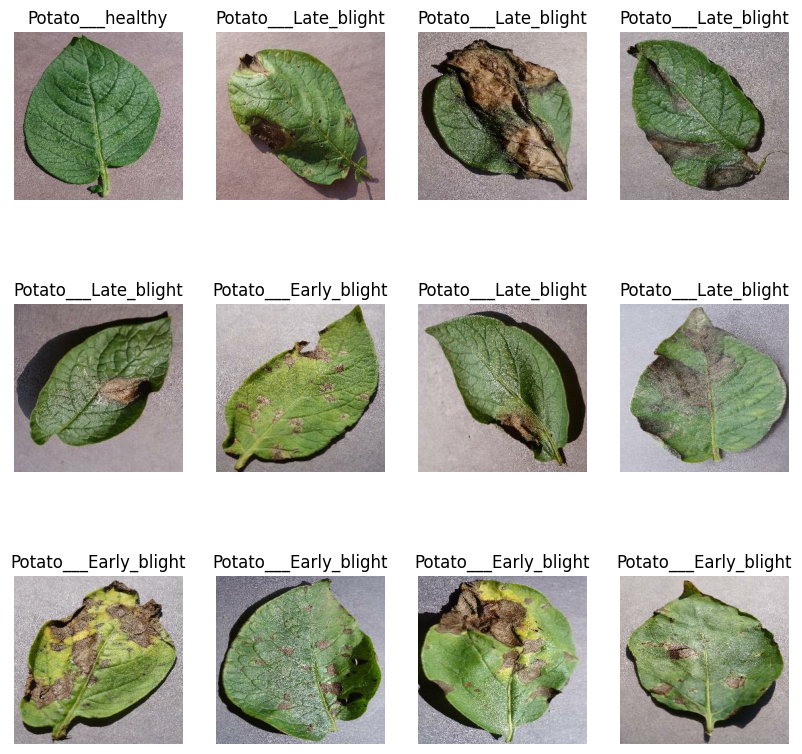

In [9]:
plt.figure(figsize=(10,10))

for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8")) #uint8 rgb değerlerini almasını sağlıyo
        plt.title(class_names[label_batch[i]])
        plt.axis("off")


In [10]:
# 0.8 training, 0.1 validation, 0.1 test olacak. her epoch sonunda 
# validation uygulıycaz. 50 epoch bitip de elimizde final model olunca 
# test edicez

train_size = 0.8
len(dataset)*train_size

54.400000000000006

In [11]:
train_ds = dataset.take(54) #first 54

In [12]:
test_ds = dataset.skip(54) #remaining
len(test_ds)

14

In [13]:
val_size = 0.1
len(dataset) * val_size

6.800000000000001

In [14]:
val_ds = test_ds.take(6)

In [15]:
test_ds= test_ds.skip(6) #8

In [16]:
##bunun hepsini fonk ile yaparsak :

def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1,shuffle=True, shuffle_size=10000):
    
    ds_size = len(ds)

    if shuffle:
        ds= ds.shuffle(shuffle_size, seed=12)

    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)

    train_ds=ds.take(train_size)

    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [17]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [18]:
len(train_ds)

54

In [19]:
len(val_ds)

6

In [20]:
len(test_ds)

8

In [21]:
#cachede olması tekradan kullanım gerekirse diye memoryde tutulmasını sağlayacak ve performansı arttıracak

train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds= test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

In [22]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [23]:
#data augmentation >> orijinal imagei alıp horizontal flip, contrast, rotation, 
# zoom uygulayıp daha fazla image elde ediyosun ve bu modelin daha iyi öğrenmesini sağlıyor

data_auggmentation= tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

### model building

In [24]:
input_shape = (BATCH_SIZE,IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes=3

model = models.Sequential([
    resize_and_rescale,
    data_auggmentation,
    layers.Conv2D(32,(3,3), activation="relu", input_shape=input_shape),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,(3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Conv2D(64,kernel_size=(3,3), activation="relu"),
    layers.MaxPooling2D(2,2),
    layers.Flatten(),
    layers.Dense(64,activation="relu"),
    layers.Dense(n_classes, activation="softmax"),
])

In [25]:
model.build(input_shape=input_shape)

In [26]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [27]:
model.compile(
    optimizer = "adam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"]
)

In [28]:
history = model.fit(
    train_ds,
    epochs= EPOCHS,
    batch_size= BATCH_SIZE,
    verbose=1,
    validation_data = val_ds
)

Epoch 1/10
54/54 [==============================] - 64s 1s/step - loss: 0.9358 - accuracy: 0.4786 - val_loss: 0.8649 - val_accuracy: 0.7292
Epoch 2/10
54/54 [==============================] - 58s 1s/step - loss: 0.8451 - accuracy: 0.5804 - val_loss: 0.7244 - val_accuracy: 0.6979
Epoch 3/10
54/54 [==============================] - 57s 1s/step - loss: 0.5776 - accuracy: 0.7633 - val_loss: 0.3996 - val_accuracy: 0.8385
Epoch 4/10
54/54 [==============================] - 56s 1s/step - loss: 0.3386 - accuracy: 0.8571 - val_loss: 0.2197 - val_accuracy: 0.9062
Epoch 5/10
54/54 [==============================] - 58s 1s/step - loss: 0.3146 - accuracy: 0.8675 - val_loss: 0.2135 - val_accuracy: 0.9271
Epoch 6/10
54/54 [==============================] - 59s 1s/step - loss: 0.2200 - accuracy: 0.9161 - val_loss: 0.2402 - val_accuracy: 0.9062
Epoch 7/10
54/54 [==============================] - 57s 1s/step - loss: 0.2166 - accuracy: 0.9196 - val_loss: 0.1604 - val_accuracy: 0.9375
Epoch 8/10
54/54 [==

In [29]:
scores =model.evaluate(test_ds)

8/8 [==============================] - 3s 233ms/step - loss: 0.2406 - accuracy: 0.9062


In [30]:
scores

[0.24060887098312378, 0.90625]

In [31]:
history

In [32]:
history.params

{'verbose': 1, 'epochs': 10, 'steps': 54}

In [33]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [34]:
history.history["accuracy"]

[0.47858795523643494,
 0.5804398059844971,
 0.7633101940155029,
 0.8570601940155029,
 0.8674768805503845,
 0.9160879850387573,
 0.9195601940155029,
 0.9236111044883728,
 0.9328703880310059,
 0.9571759104728699]

In [35]:
acc = history.history["accuracy"]
val_acc = history.history["val_accuracy"]

loss = history.history["loss"]
val_loss=val_acc = history.history["val_loss"]

Text(0.5, 1.0, 'training and validation loss')

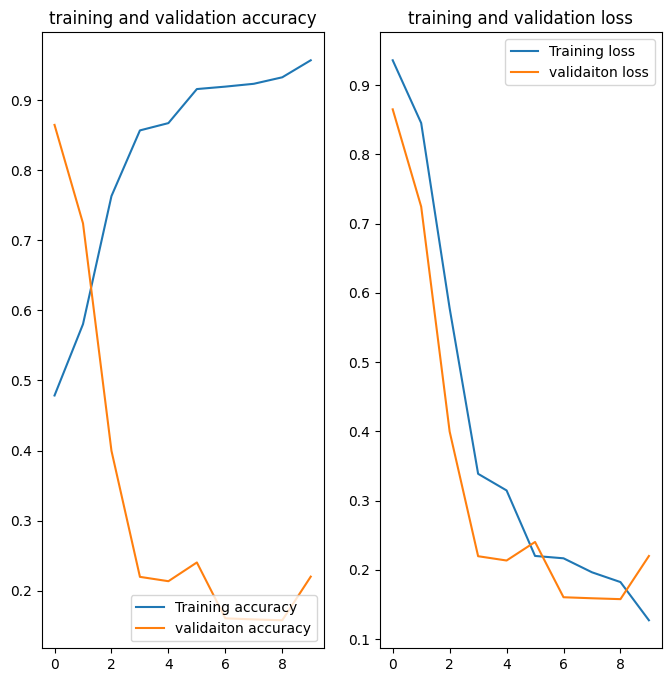

In [36]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCHS), acc, label="Training accuracy")
plt.plot(range(EPOCHS), val_acc, label="validaiton accuracy")
plt.legend(loc="lower right")
plt.title("training and validation accuracy")

plt.subplot(1,2,2)
plt.plot(range(EPOCHS), loss, label="Training loss")
plt.plot(range(EPOCHS), val_loss, label="validaiton loss")
plt.legend(loc="upper right")
plt.title("training and validation loss")

first image to predict
actual label: Potato___Early_blight
1/1 [==============================] - 0s 300ms/step
predicted label: Potato___Early_blight


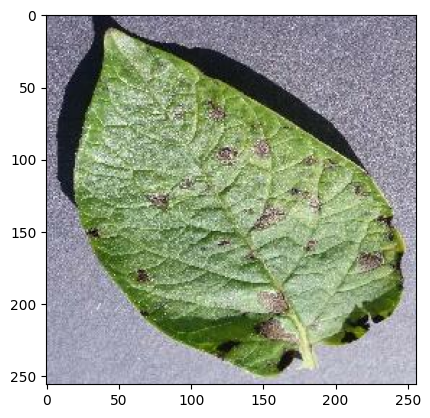

In [37]:
import numpy as np

for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype("uint8")
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:", class_names[first_label])

    batch_prediction= model.predict(images_batch)
    print("predicted label:", class_names[np.argmax(batch_prediction[0])] )

In [38]:
def predict(model,img):
    img_array= tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array= tf.expand_dims(img_array,0) #create a batch

    predictions= model.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100*(np.max(predictions[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 30ms/step


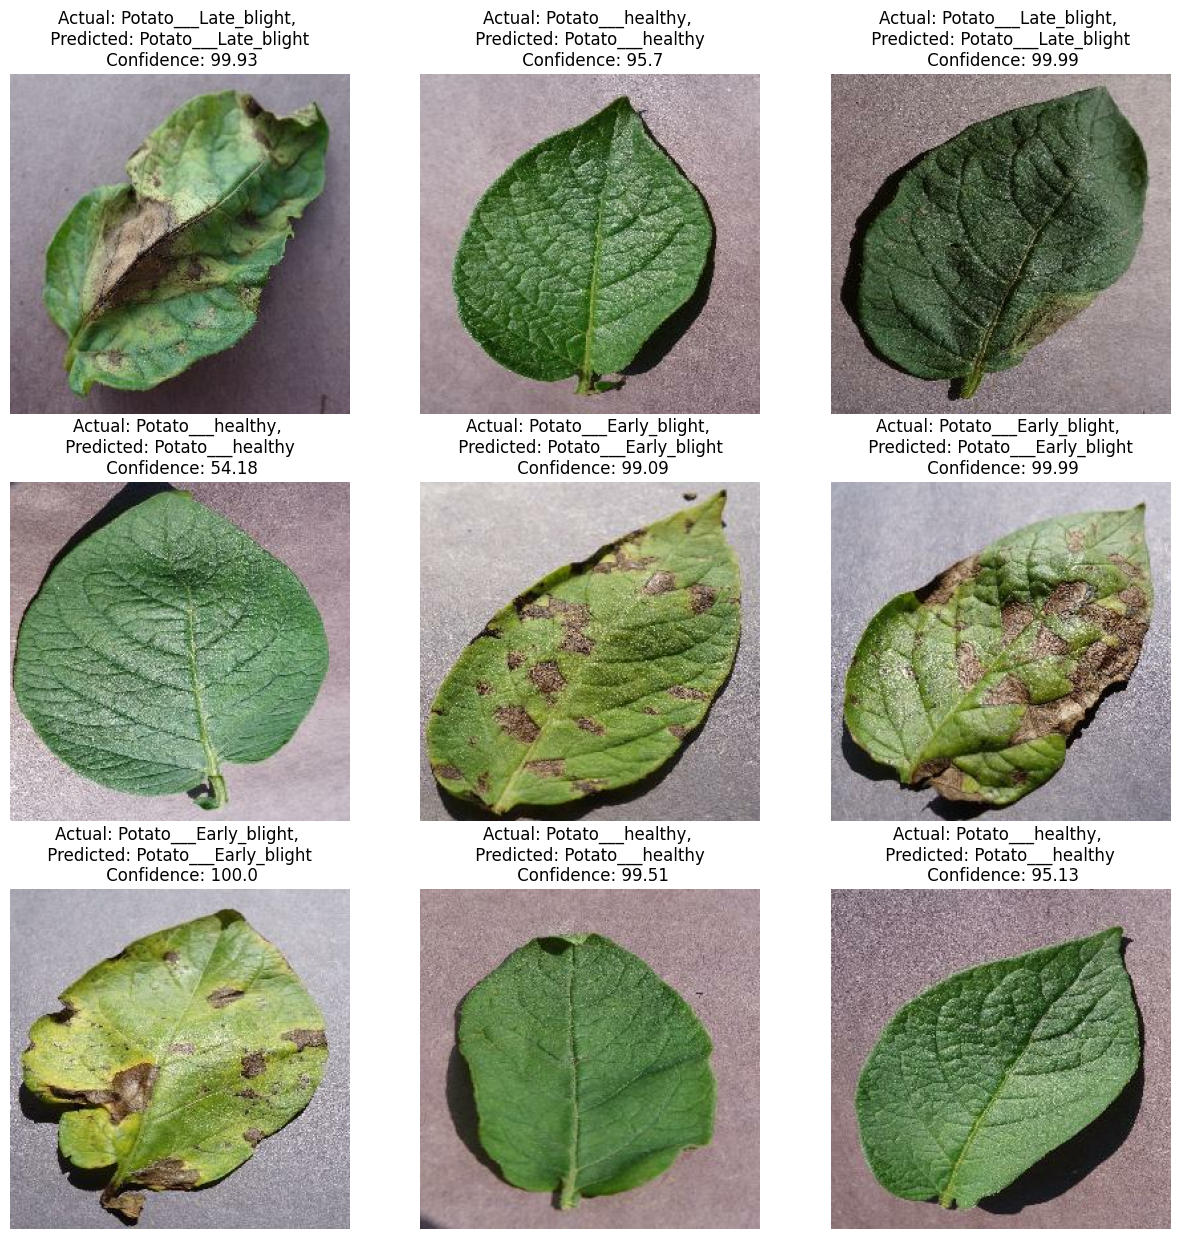

In [39]:
plt.figure(figsize=(15,15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class= class_names[labels[i]]

        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class} \n Confidence: {confidence}")

        plt.axis("off")

In [40]:
import os
model_version = max([int (i) for i in os.listdir("../saved_models") + [0]]) + 1
model.save(f"../saved_models/{model_version}")

#bu sayede yeni bir model versiyonu yapıldığında otomatik kaydedecek

INFO:tensorflow:Assets written to: ../saved_models/2\assets


INFO:tensorflow:Assets written to: ../saved_models/2\assets
